# Cursive English Handwritten Character Classification: Exploratory Data Analysis
# ------------------------------------------------------------------------------

### Notebook Overview:
This notebook will be used to explore and understand the cursive handwriting dataset derived from the CVL database. We will be:
1. Previewing Dataset
2. Check Data Quality and Clean
3. Class Distribution Analysis
4. Visual Explorations
5. Statistical Summaries
6. Preliminary Feature or Embedding Analysis
7. EDA Conclusion

In [1]:
%pip install torchsummary pytest
%pip install pandas matplotlib seaborn pillow torchvision scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
from importlib import reload

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if flag_cuda:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


## 1. Preview the Data
### In this section, we will:
### 1. Examine the folder structure for our dataset.
### 2. Count how many files are in each subdirectory.
### 3. Visualize a few random images from the `lines`, `pages`, and `words` directories.

Folder Structure and File Counts:
- words: 99592 files found
Displaying random images from 'words' folder:


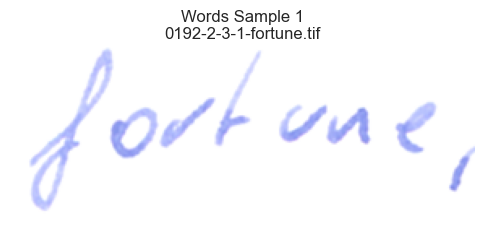

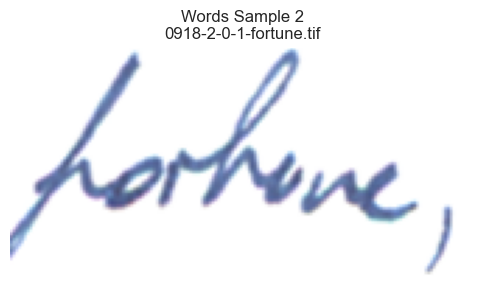

In [3]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Base path for the raw dataset
BASE_PATH = os.path.normpath('cvl-database-1-1/raw_dataset')

# Since only the words folder exists now, we use that:
subfolders = ['words']

print("Folder Structure and File Counts:")
for folder in subfolders:
    folder_path = os.path.join(BASE_PATH, folder)
    all_files = glob.glob(os.path.join(folder_path, '**', '*.*'), recursive=True)
    print(f"- {folder}: {len(all_files)} files found")

def show_random_image(folder_name, num_samples=1):
    """
    Display 'num_samples' random images from the specified folder (including its subfolders).
    """
    folder_path = os.path.join(BASE_PATH, folder_name)
    # Adjust file extension as needed (here using .tif)
    image_files = glob.glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)
    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return
    random_files = random.sample(image_files, k=min(num_samples, len(image_files)))
    for i, file_path in enumerate(random_files, 1):
        img = Image.open(file_path)
        plt.figure(figsize=(6, 4))
        plt.imshow(img, cmap='gray')  # Adjust cmap if images are RGB.
        plt.title(f"{folder_name.capitalize()} Sample {i}\n{os.path.basename(file_path)}")
        plt.axis('off')
        plt.show()

for folder_name in subfolders:
    print(f"Displaying random images from '{folder_name}' folder:")
    show_random_image(folder_name, num_samples=2)


# 2. Data Quality and Cleaning

In [4]:
import os
import glob
import re

# Base path for the raw dataset
BASE_PATH = os.path.normpath('cvl-database-1-1/raw_dataset')

def filter_german_files(folder_name, extension='tif'):
    folder_path = os.path.join(BASE_PATH, folder_name)
    all_files = glob.glob(os.path.join(folder_path, '**', f'*.{extension}'), recursive=True)
    all_files = [os.path.normpath(f) for f in all_files]

    # Filter out files where the base name contains '-6-'
    filtered_files = [f for f in all_files if not re.search(r'-6-', os.path.basename(f))]
    print(f"Folder: {folder_name} - Original count: {len(all_files)}, Filtered count: {len(filtered_files)}")
    return filtered_files

# Process the 'words' folder only
words_filtered = filter_german_files('words')

Folder: words - Original count: 99592, Filtered count: 68968


In [5]:
from PIL import Image, ImageOps
import os

def resize_image_to_uniform_size(image_path, target_width, target_height):
    # Open the image
    img = Image.open(image_path)
    current_width, current_height = img.size
    # Calculate padding to center the image within the target dimensions
    padding_left = (target_width - current_width) // 2
    padding_top = (target_height - current_height) // 2
    padding_right = target_width - current_width - padding_left
    padding_bottom = target_height - current_height - padding_top
    # Add padding with a white background (RGB white: 255, 255, 255)
    padded_img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom), (255, 255, 255))
    return padded_img

def process_images_in_folder(file_list, target_width, target_height, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Process each file in the list
    for filename in file_list:
        if filename.lower().endswith('.tif'):
            padded_image = resize_image_to_uniform_size(filename, target_width, target_height)
            output_path_save = os.path.join(output_path, os.path.basename(filename))
            padded_image.save(output_path_save)

# Define the output path under preprocessed_dataset
words_output_folder = os.path.normpath(os.path.join('cvl-database-1-1', 'preprocessed_dataset', 'words_padded'))

# Set the target size (these values are based on your stats)
target_width = 1756  # Largest width from the stats
target_height = 146  # Largest height from the stats

# Process all .tif images in the 'words' folder
process_images_in_folder(words_filtered, target_width, target_height, words_output_folder)